In [1]:
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from configobj import ConfigObj

# Custom modules from the project
from graphnet import EncodeProcessDecode
from Dataset import EfficientDataset

from scipy.interpolate import interpn

In [2]:
# Check if CUDA is available and set the device
gpu = 0
cuda_available = torch.cuda.is_available()
device = torch.device(f"cuda:{gpu}" if cuda_available else "cpu")

print(f"CUDA available: {cuda_available}")
print(f"Using device: {device}")

CUDA available: True
Using device: cuda:0


In [3]:
# Load the datacubes from the original C Porta code output
datadir = '../data_porta'
grid_file = '../en024048_hion/grid_bifrost.npz'
# Define the path to your best saved model
checkpoint_path = 'checkpoints/claud_norm/2025.09.27-06:23:06_best.pth' # Make sure this path is correct
# checkpoint_path = 'checkpoints/cos_annealing_300/2025.07.31-09:06:14_best.pth' # Make sure this path is correct

nx = ny = 504
nz = 476 - 52 + 1  # 425
new_nz = 64
batch_size = 64

# Use memory-mapped arrays to handle large files efficiently
pops_orig = np.memmap(f'{datadir}/AR_385_CaII_5L_pops.dat', dtype='<f4', mode='r', shape=(nz, ny, nx, 6))
b_xyz_orig = np.memmap(f'{datadir}/AR_385_B.dat', dtype='<f4', mode='r', shape=(nz, ny, nx, 3))
temp_orig = np.memmap(f'{datadir}/AR_385_temp.dat', dtype='<f4', mode='r', shape=(nz, ny, nx, 1))
vel_orig = np.memmap(f'{datadir}/AR_385_veloc.dat', dtype='<f4', mode='r', shape=(nz, ny, nx, 3))
n_e_orig = np.memmap(f'{datadir}/AR_385_ne.dat', dtype='<f4', mode='r', shape=(nz, ny, nx, 1))
n_h_orig = np.memmap(f'{datadir}/AR_385_nh.dat', dtype='<f4', mode='r', shape=(nz, ny, nx, 1))
n_p_orig = np.memmap(f'{datadir}/AR_385_np.dat', dtype='<f4', mode='r', shape=(nz, ny, nx, 1))

In [4]:
# Interpolate the data to the model's expected input dimensions (new_nz, 504, 504)
z, y, x = (np.arange(d) for d in (nz, ny, nx))
new_z, new_y, new_x = (np.linspace(0, d-1, new_d) for d, new_d in zip((nz, ny, nx), (new_nz, ny, nx)))
new_zv, new_yv, new_xv = np.meshgrid(new_z, new_y, new_x, indexing='ij', sparse=True)
new_points = (new_zv, new_yv, new_xv)

print(f"Interpolating data to the new grid ({new_nz}, {ny}, {nx})...")
pops = interpn((z, y, x), pops_orig, new_points)
temp = interpn((z, y, x), temp_orig, new_points)
b_xyz = interpn((z, y, x), b_xyz_orig, new_points)
vel = interpn((z, y, x), vel_orig, new_points)
n_e = interpn((z, y, x), n_e_orig, new_points)
n_h = interpn((z, y, x), n_h_orig, new_points)
n_p = interpn((z, y, x), n_p_orig, new_points)
print("Interpolation complete.")

Interpolating data to the new grid (64, 504, 504)...
Interpolation complete.


In [5]:
pops_orig.shape

(425, 504, 504, 6)

In [6]:
pops.shape

(64, 504, 504, 6)

In [7]:
# Apply robust normalization to features using percentile-based scaling
def robust_normalize(data, axis=(0,1,2)):
    """
    Apply robust normalization using percentiles instead of mean/std
    """
    # Calculate percentiles
    q25 = np.percentile(data, 25, axis=axis, keepdims=True)
    q75 = np.percentile(data, 75, axis=axis, keepdims=True)
    median = np.percentile(data, 50, axis=axis, keepdims=True)
    iqr = q75 - q25
    
    # Apply robust scaling: (x - median) / IQR
    normalized = (data - median) / (iqr + 1e-12)  # Add small epsilon to avoid division by zero
    
    return normalized, {'median': median, 'iqr': iqr}

# Apply robust normalization to velocity
vel_norm, vel_params = robust_normalize(vel)

# Apply robust normalization to magnetic field (without the complex transformation)
b_norm, b_params = robust_normalize(b_xyz)

# For temperature, use log-transform then robust scaling
temp_log = np.log10(temp + 1e-12)
temp_norm, temp_params = robust_normalize(temp_log)

# For densities, use log-transform then robust scaling
nh_log = np.log10(n_h + 1e-12)
nh_norm, nh_params = robust_normalize(nh_log)

ne_log = np.log10(n_e + 1e-12)
ne_norm, ne_params = robust_normalize(ne_log)

np_log = np.log10(n_p + 1e-12)
np_norm, np_params = robust_normalize(np_log)

# Create the normalized features list
features_list = [vel_norm, b_norm, temp_norm, nh_norm, ne_norm, np_norm]

# Store normalization parameters for all features
feature_norm_params = {
    'vel': vel_params,
    'b_xyz': b_params,
    'temp': temp_params,
    'nh': nh_params,
    'ne': ne_params,
    'np': np_params
}

# Store the original departure coefficients for later comparison
departure_coeffs_orig = pops/pops.sum(axis=-1, keepdims=True)

# Improved normalization: Apply log-transform and robust scaling
# Use robust scaling with percentiles to handle outliers better
departure_coeffs_log = np.log10(departure_coeffs_orig + 1e-12)  # Add small epsilon to avoid log(0)

# Robust scaling using percentiles instead of mean/std
q25, q75 = np.percentile(departure_coeffs_log, [25, 75], axis=(0,1,2), keepdims=True)
iqr = q75 - q25
median = np.percentile(departure_coeffs_log, 50, axis=(0,1,2), keepdims=True)

# Apply robust scaling: (x - median) / IQR
departure_coeffs_normalized = (departure_coeffs_log - median) / (iqr + 1e-12)

targets_list = [departure_coeffs_normalized]

# Store normalization parameters for denormalization
normalization_params = {
    'median': median,
    'iqr': iqr,
    'log_offset': 1e-12
}

features_labels = ['vx', 'vy', 'vz', 'bx', 'by', 'bz', 'temp', 'nh', 'ne', 'np']

# Create the test dataset and loader
datast_test = EfficientDataset(
    features_list,
    targets_list,
    pos_file=grid_file,
    radius_neighbors=1.77,
    split='test'  # Ensure we are using the test set
)

loader_test = DataLoader(datast_test, batch_size=batch_size, shuffle=False) # No need to shuffle for inference

Test dataset created. Total samples: 25201
Features shape: (16257024, 10), Targets shape: (16257024, 6)


In [8]:
# count the number of nans:
print(np.isnan(datast_test.features).sum(axis=0)/datast_test.features.shape[0])
print(np.isnan(datast_test.targets).sum(axis=0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0]


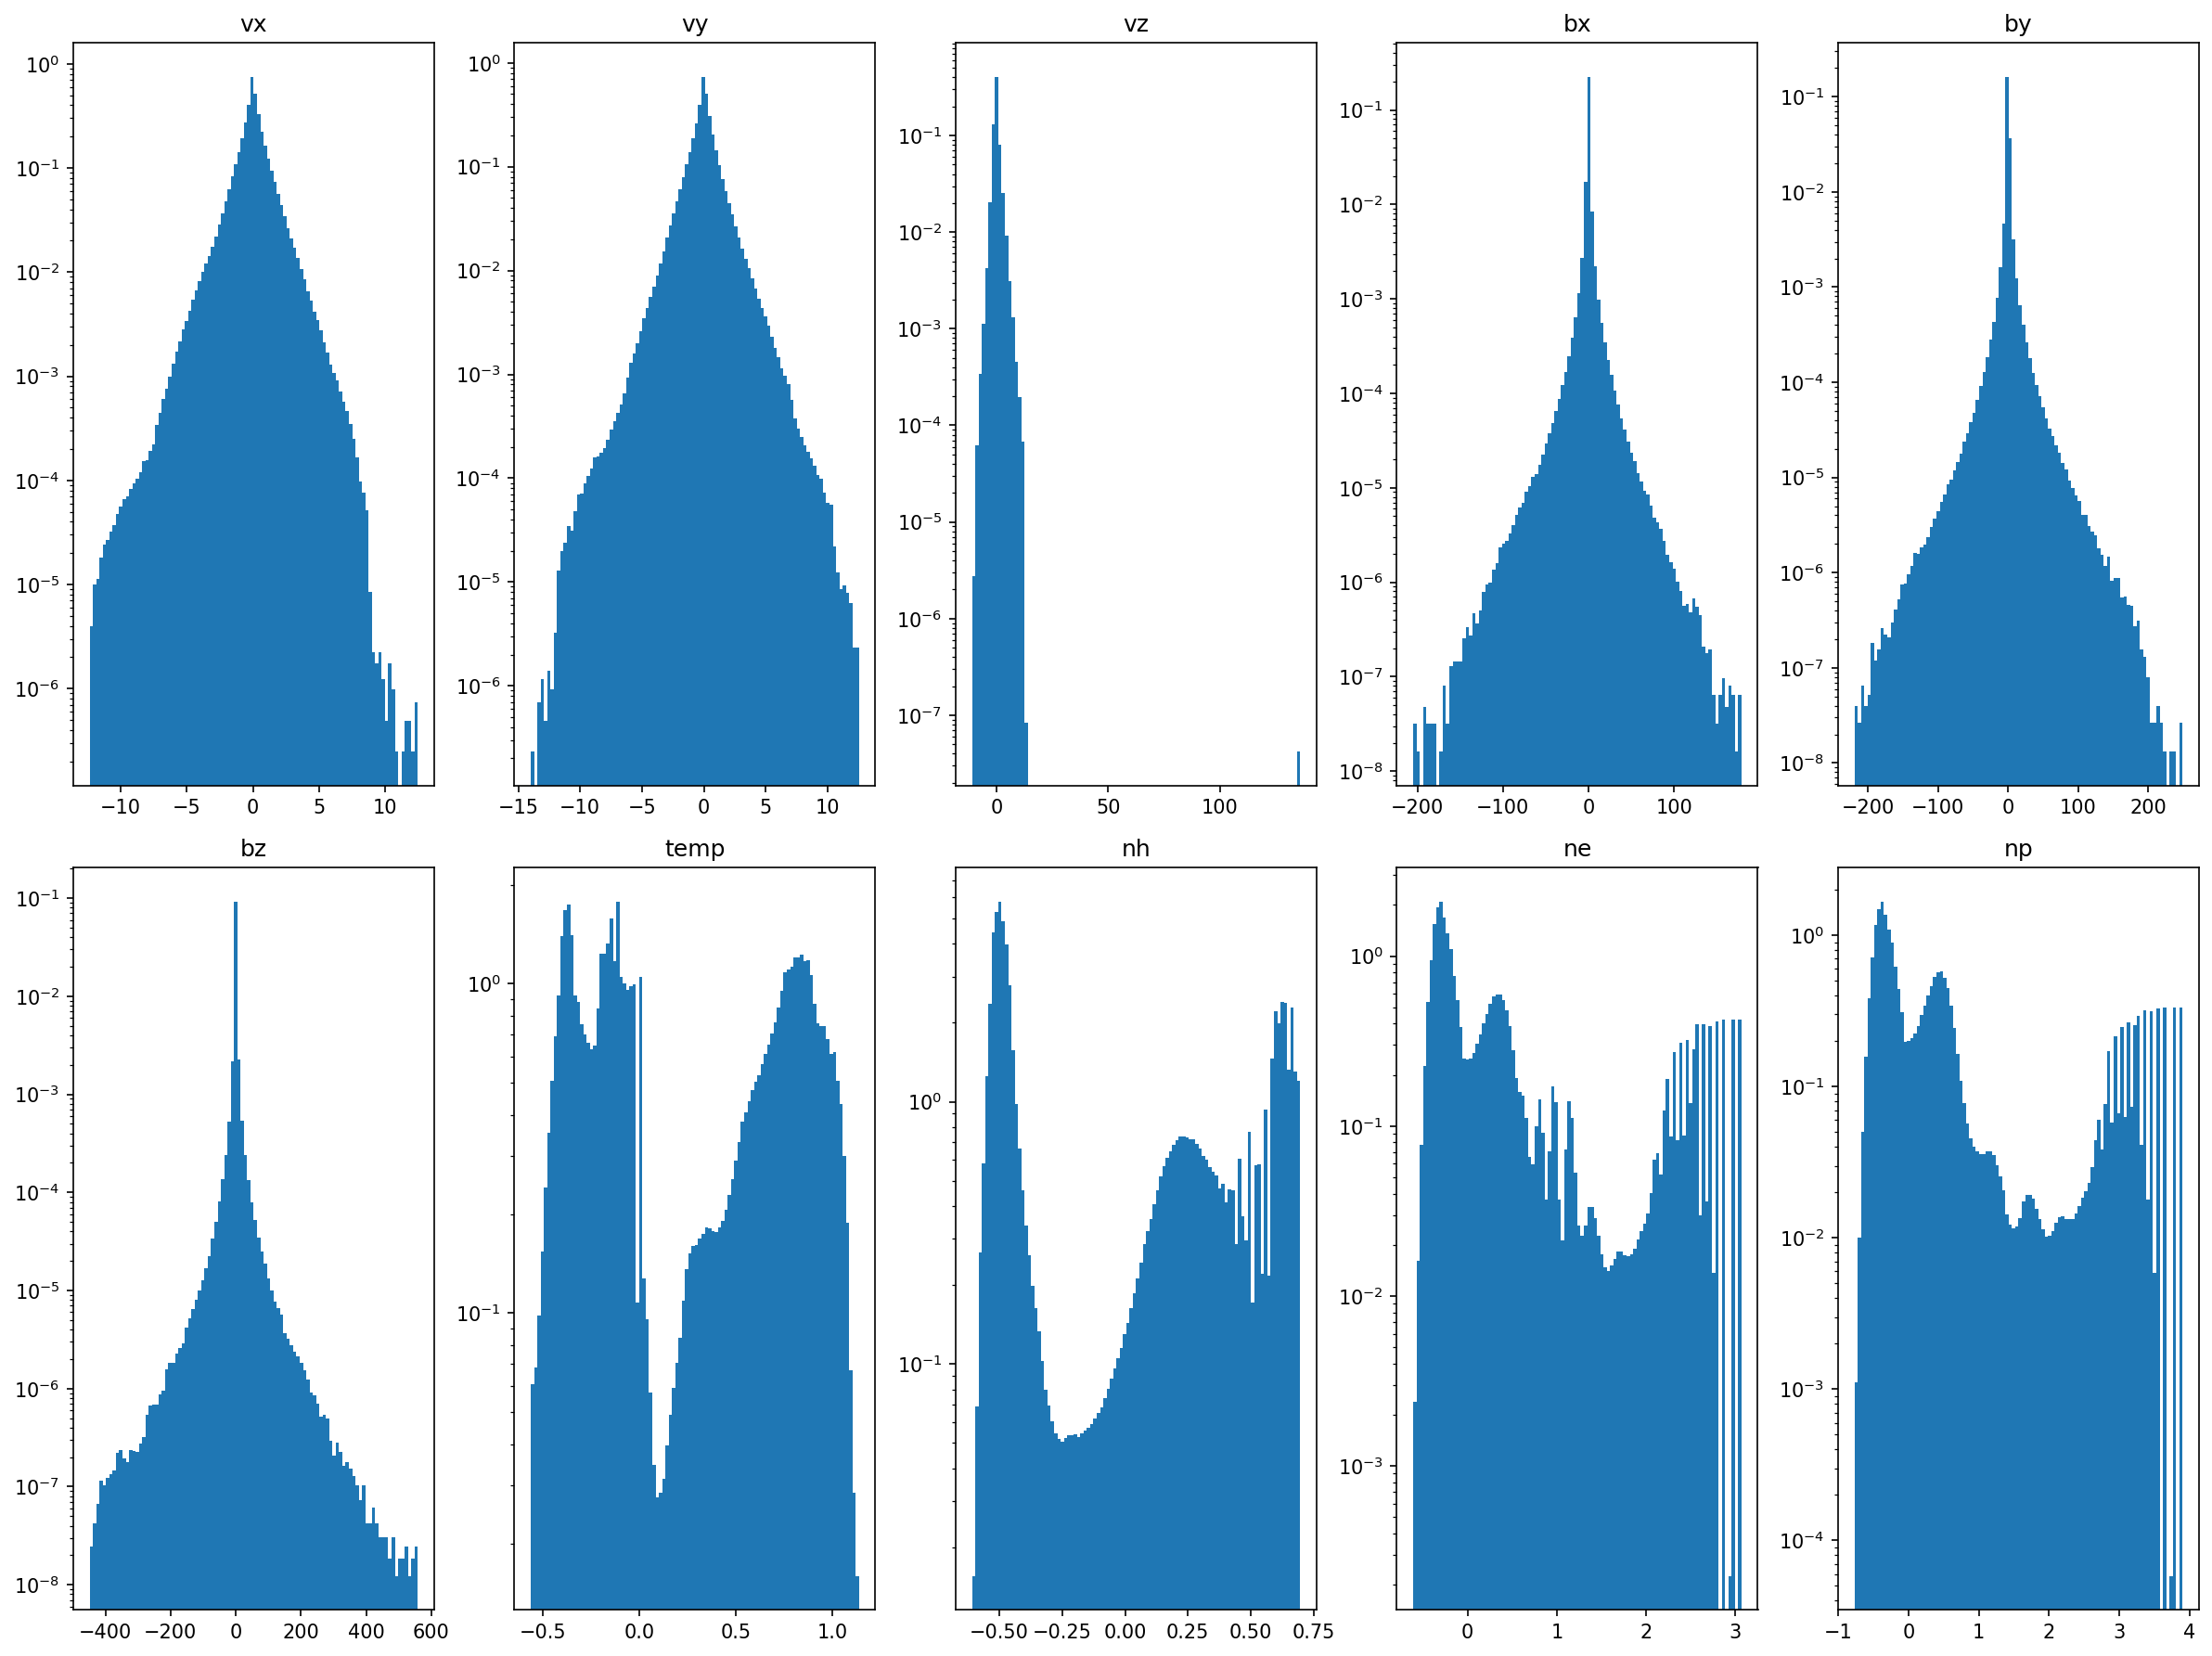

In [9]:
plt.figure(0,(16,12), 150)

for i in range(datast_test.features.shape[1]):
    plt.subplot(2,5,i+1)
    plt.title(features_labels[i])
    plt.hist(datast_test.features[:,i],100, density=True)
    plt.yscale('log')
plt.tight_layout()
plt.show()

In [10]:
# Check the normalization statistics to verify robust scaling worked properly
print("Feature normalization statistics (should be approximately centered around 0):")
print("="*60)
for i, label in enumerate(features_labels):
    feature_data = datast_test.features[:, i]
    q25, median, q75 = np.percentile(feature_data, [25, 50, 75])
    iqr = q75 - q25
    print(f"{label:>6}: median={median:>6.3f}, IQR={iqr:>6.3f}, "
          f"min={feature_data.min():>7.3f}, max={feature_data.max():>7.3f}")

print(f"\nTarget normalization statistics:")
print("="*60)
for i in range(datast_test.targets.shape[1]):
    target_data = datast_test.targets[:, i]
    q25, median, q75 = np.percentile(target_data, [25, 50, 75])
    iqr = q75 - q25
    print(f"Ca II Level {i+1}: median={median:>6.3f}, IQR={iqr:>6.3f}, "
          f"min={target_data.min():>7.3f}, max={target_data.max():>7.3f}")

print(f"\nWith robust scaling, the median should be ~0 and IQR should be ~1.0")
print(f"This confirms the normalization is working correctly.")

Feature normalization statistics (should be approximately centered around 0):
    vx: median= 0.000, IQR= 1.000, min=-12.356, max= 12.470
    vy: median= 0.000, IQR= 1.000, min=-13.989, max= 12.547
    vz: median=-0.000, IQR= 1.000, min=-10.914, max=135.947
    bx: median=-0.000, IQR= 1.000, min=-204.787, max=178.619
    by: median= 0.000, IQR= 1.000, min=-219.369, max=248.945
    bz: median= 0.000, IQR= 1.000, min=-448.271, max=558.764
  temp: median= 0.000, IQR= 1.000, min= -0.564, max=  1.137
    nh: median= 0.000, IQR= 1.000, min= -0.609, max=  0.697
    ne: median= 0.000, IQR= 1.000, min= -0.609, max=  3.067
    np: median=-0.000, IQR= 1.000, min= -0.772, max=  3.900

Target normalization statistics:
Ca II Level 1: median=-0.000, IQR= 1.000, min= -0.386, max=  0.925
Ca II Level 2: median= 0.000, IQR= 1.000, min= -0.381, max=  1.120
Ca II Level 3: median= 0.000, IQR= 1.000, min= -0.383, max=  1.108
Ca II Level 4: median=-0.000, IQR= 1.000, min= -0.375, max=  1.573
Ca II Level 5: me

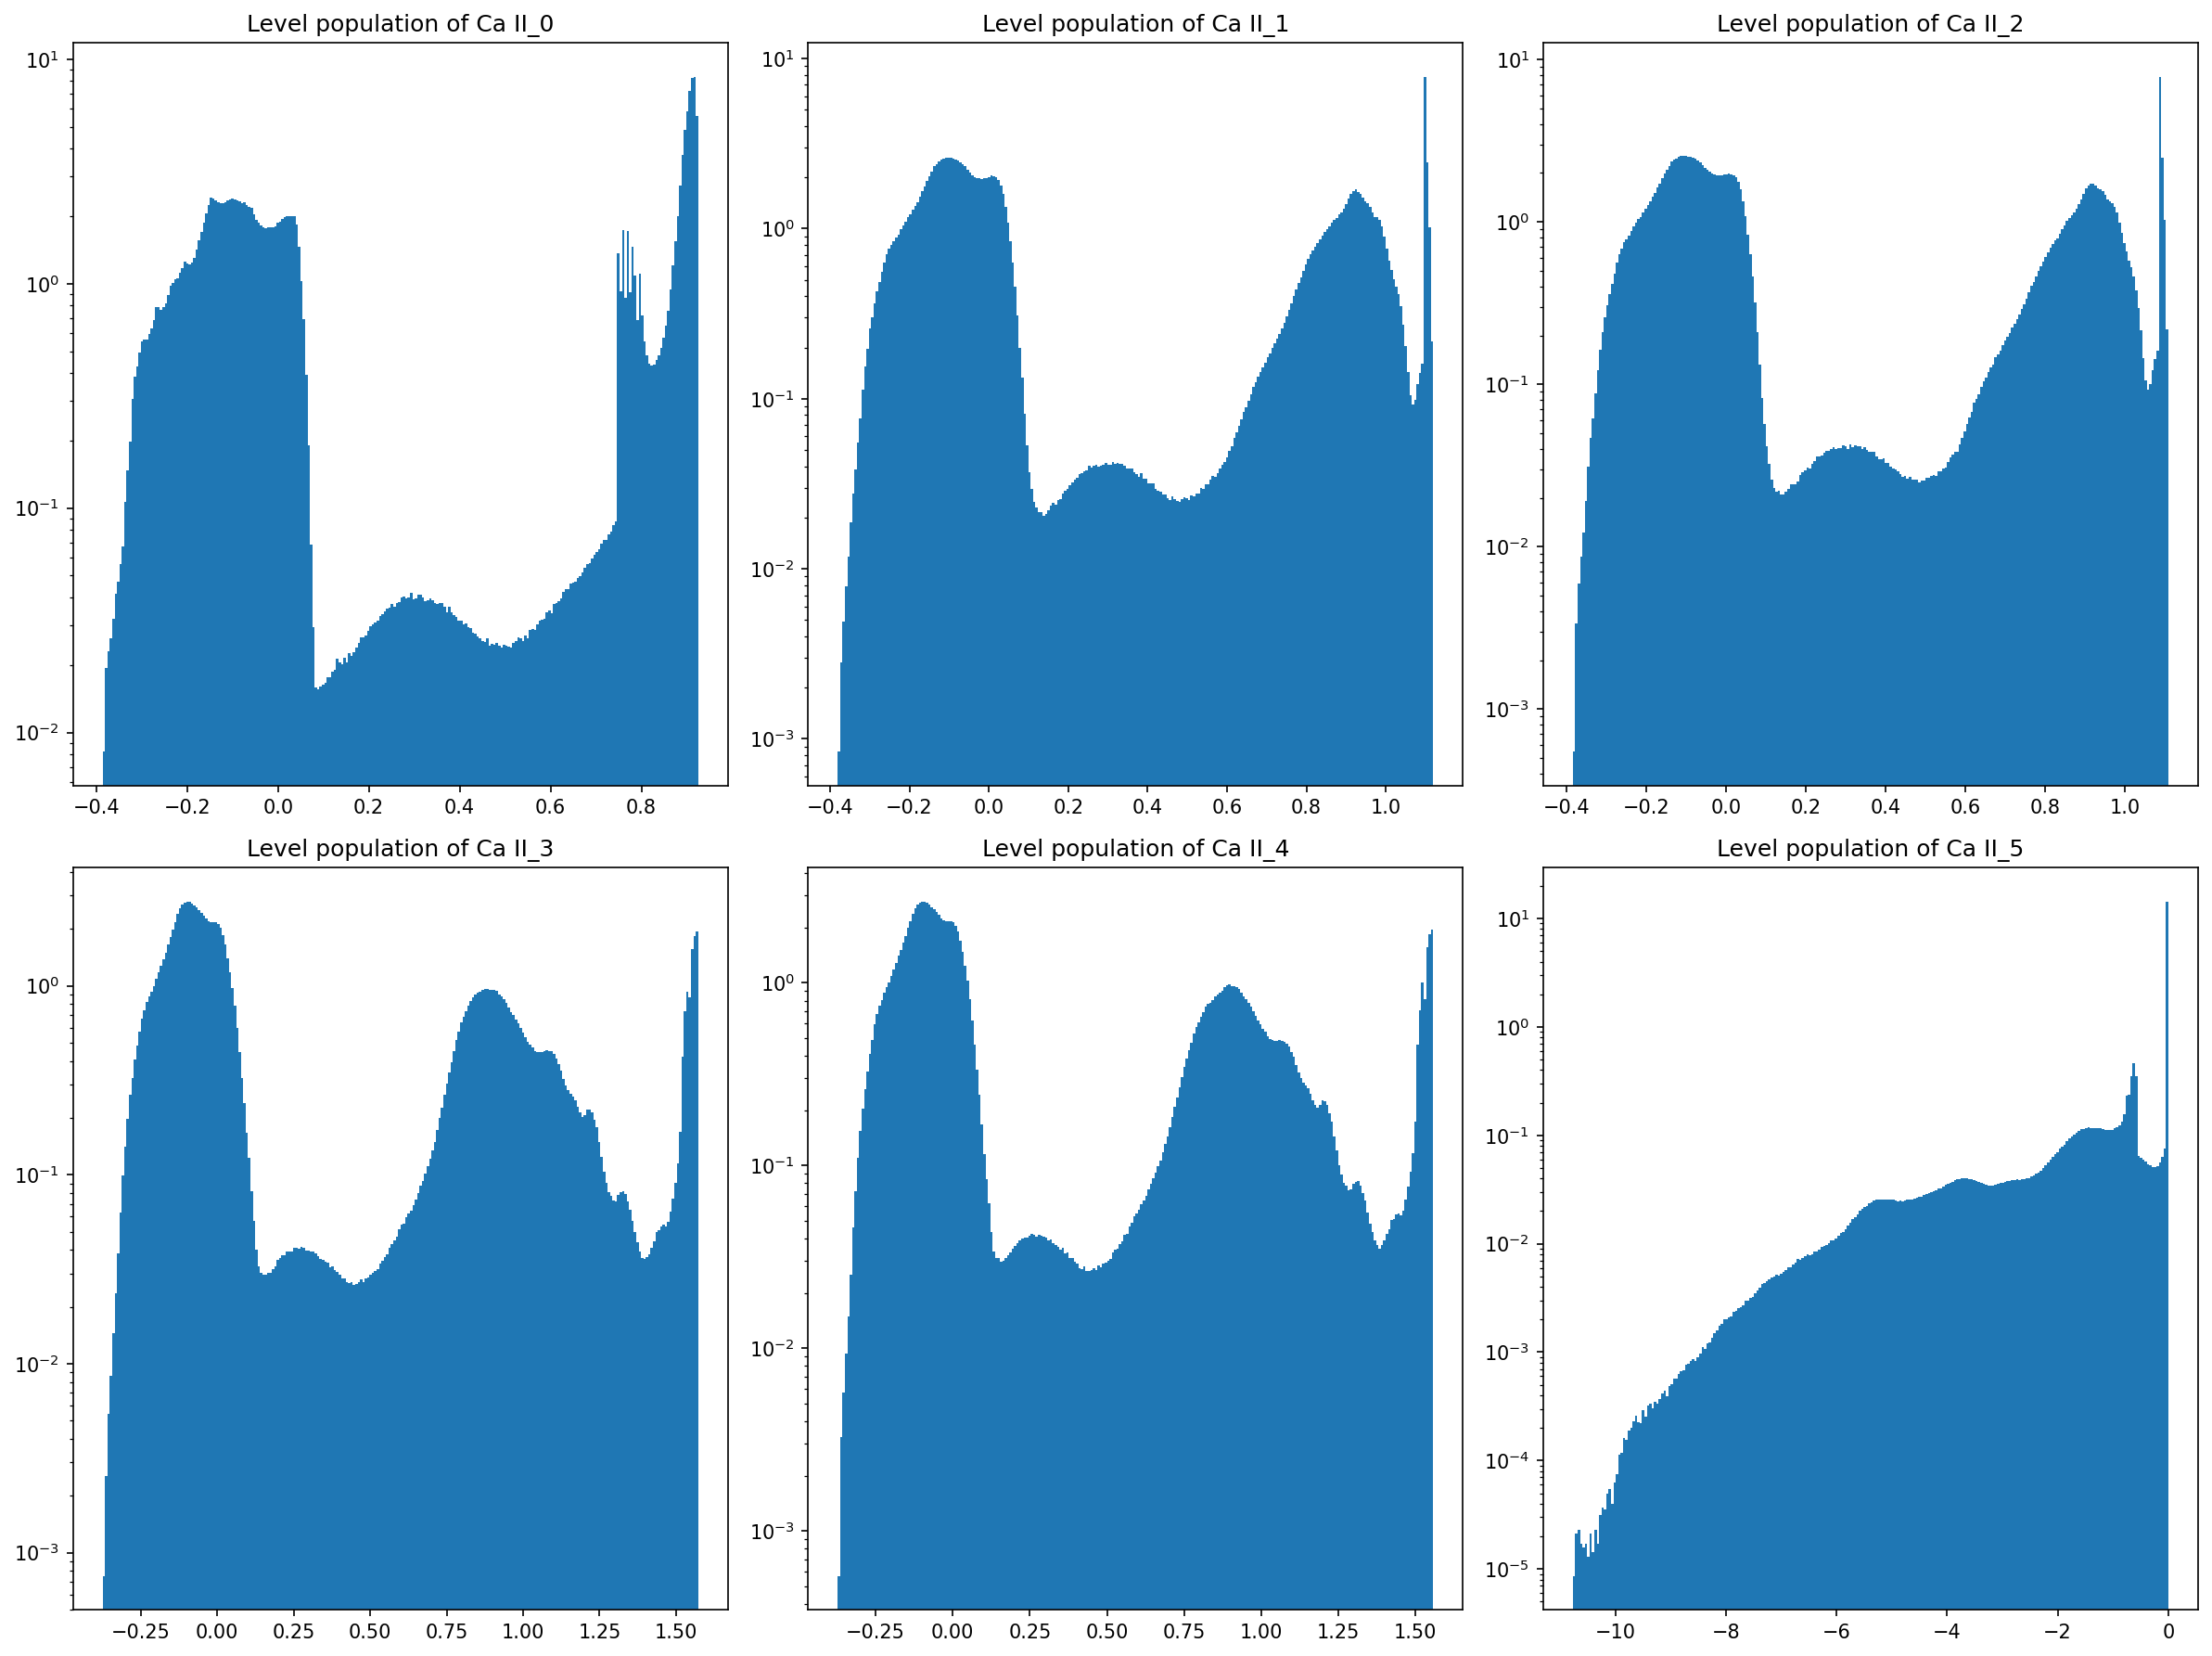

In [11]:
plt.figure(0,(16,12), 150)
for i in range(datast_test.targets.shape[1]):
    plt.subplot(2,3,i+1)
    plt.title(f'Level population of Ca II_{i}')
    plt.hist(datast_test.targets[:,i],250, density=True)
    plt.yscale('log')
plt.tight_layout()
plt.show()

In [12]:
# Load the checkpoint dictionary
# Use map_location to ensure the model loads correctly on CPU if it was trained on GPU
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

# Extract hyperparameters and instantiate the model
hyperparameters = checkpoint['hyperparameters']
for k, v in hyperparameters.items(): # Ensure hyperparameters are integers
    hyperparameters[k] = int(v)

model = EncodeProcessDecode(**hyperparameters).to(device)

# Load the trained weights into the model
model.load_state_dict(checkpoint['state_dict'])

print("Model loaded successfully from checkpoint.")
print(f"Loaded model from epoch {checkpoint['epoch']} with best validation loss: {checkpoint['best_loss']:.6f}")

# Check if the checkpoint contains normalization parameters (for newer models)
if 'normalization_params' in checkpoint:
    print("Using normalization parameters from checkpoint (trained with robust normalization)")
    normalization_params = checkpoint['normalization_params']
    feature_norm_params = checkpoint['feature_norm_params']
    
    # The model was trained with robust normalization, so we need to use the same parameters
    # Note: We would need to recompute features using the saved parameters, but for this inference
    # we'll use the current normalization since we're using the same data
    print("Checkpoint contains saved normalization parameters")
else:
    print("Using current normalization parameters (checkpoint trained with old normalization)")
    # Use the normalization parameters we computed above
    print("Using locally computed normalization parameters")

Model loaded successfully from checkpoint.
Loaded model from epoch 38 with best validation loss: 0.045671
Using normalization parameters from checkpoint (trained with robust normalization)
Checkpoint contains saved normalization parameters


In [13]:
all_predictions = []
all_targets = []

model.eval() # Set the model to evaluation mode

print("Running inference on the test set...")
with torch.no_grad(): # Disable gradient calculations for inference
    for data in tqdm(loader_test):
        # Move data to the selected device
        node, edge_attr, edge_index = data.x.to(device), data.edge_attr.to(device), data.edge_index.to(device)
        u, batch, target = data.u.to(device), data.batch.to(device), data.y.to(device)

        # Get model prediction
        out = model(node, edge_attr, edge_index, u, batch)

        # Store predictions and targets
        # Move them to CPU and convert to NumPy arrays for analysis
        all_predictions.append(out.cpu().numpy())
        all_targets.append(target.cpu().numpy())

# Concatenate all batch results into single NumPy arrays
predictions = np.concatenate(all_predictions, axis=0)
targets = np.concatenate(all_targets, axis=0)

print("Inference complete.")
print(f"Predictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")

Running inference on the test set...


100%|██████████| 40/40 [00:26<00:00,  1.53it/s]

Inference complete.
Predictions shape: (1451520, 6)
Targets shape: (1451520, 6)


In [14]:
# Function to denormalize predictions back to original departure coefficient space
def denormalize_predictions(normalized_preds, norm_params):
    """
    Denormalize predictions from robust-scaled log space back to departure coefficients
    """
    # Squeeze the normalization parameters to remove extra dimensions
    iqr = norm_params['iqr'].squeeze()
    median = norm_params['median'].squeeze()
    
    # Revert robust scaling: x_log = normalized * IQR + median
    log_preds = normalized_preds * iqr + median
    
    # Revert log transform: departure_coeffs = 10^(log_preds) - epsilon
    departure_coeffs = 10**(log_preds) - norm_params['log_offset']
    
    return departure_coeffs

# Denormalize both predictions and targets to original departure coefficient space
predictions_denorm = denormalize_predictions(predictions, normalization_params)
targets_denorm = denormalize_predictions(targets, normalization_params)

# Debug the shapes to understand the issue
print(f"predictions_denorm shape: {predictions_denorm.shape}")
print(f"targets_denorm shape: {targets_denorm.shape}")
print(f"datast_test.features shape: {datast_test.features.shape}")
print(f"Expected total points: {new_nz * ny * nx} = {new_nz} * {ny} * {nx}")

# Fix the reshaping calculation - the issue is that predictions/targets have fewer points
# This happens because the dataset might be using a different split or sampling
total_predictions = predictions_denorm.shape[0]
points_per_sample = new_nz * ny * nx
n_samples_calc = total_predictions // points_per_sample

print(f"Total predictions: {total_predictions}")
print(f"Points per sample: {points_per_sample}")
print(f"Calculated n_samples: {n_samples_calc}")

# Only reshape if we have complete samples
if total_predictions % points_per_sample == 0 and n_samples_calc > 0:
    predictions_spatial = predictions_denorm.reshape(n_samples_calc, new_nz, ny, nx, 6)
    targets_spatial = targets_denorm.reshape(n_samples_calc, new_nz, ny, nx, 6)
    print(f"Successfully reshaped to spatial format: {predictions_spatial.shape}")
else:
    print("Cannot reshape to exact spatial format - using flattened arrays for analysis")
    predictions_spatial = None
    targets_spatial = None

# Calculate residuals and errors on the original departure coefficients
residuals_denorm = (predictions_denorm - targets_denorm) / (targets_denorm + 1e-12)  # Add small epsilon to avoid division by zero
mae_denorm = np.mean(np.abs(residuals_denorm), axis=0)

# Also calculate RMSE for better comparison
rmse_denorm = np.sqrt(np.mean(residuals_denorm**2, axis=0))

print(f"MAE on original departure coefficients: {mae_denorm}")
print(f"RMSE on original departure coefficients: {rmse_denorm}")

# Calculate statistics on the original departure coefficients for reference
print(f"\nOriginal departure coefficient ranges:")
for i in range(6):
    print(f"Level {i+1}: min={targets_denorm[:,i].min():.2e}, max={targets_denorm[:,i].max():.2e}, "
          f"mean={targets_denorm[:,i].mean():.2e}")

# Keep old calculation for comparison if needed
residuals_normalized = (predictions - targets)/(targets + 1e-12)  # Add epsilon to avoid division by zero
mae_normalized = np.mean(np.abs(residuals_normalized), axis=0)
print(f"\nFor comparison - MAE on normalized values: {mae_normalized}")

predictions_denorm shape: (1451520, 6)
targets_denorm shape: (1451520, 6)
datast_test.features shape: (16257024, 10)
Expected total points: 16257024 = 64 * 504 * 504
Total predictions: 1451520
Points per sample: 16257024
Calculated n_samples: 0
Cannot reshape to exact spatial format - using flattened arrays for analysis
MAE on original departure coefficients: [0.43911534 0.51077909 0.52113332 0.50351455 0.51746473 2.44130843]
RMSE on original departure coefficients: [ 2.64227822  2.783628    2.87120656  2.43029558  2.55902015 61.76617503]

Original departure coefficient ranges:
Level 1: min=7.29e-05, max=9.95e-01, mean=2.75e-01
Level 2: min=1.22e-06, max=1.45e-01, mean=1.85e-02
Level 3: min=1.90e-06, max=2.16e-01, mean=2.82e-02
Level 4: min=8.23e-09, max=1.77e-02, mean=1.17e-03
Level 5: min=1.50e-08, max=3.46e-02, mean=2.27e-03
Level 6: min=7.53e-09, max=1.00e+00, mean=6.75e-01

For comparison - MAE on normalized values: [ 23.009708    5.0913043  15.495234    4.9281087   4.2368474 133.

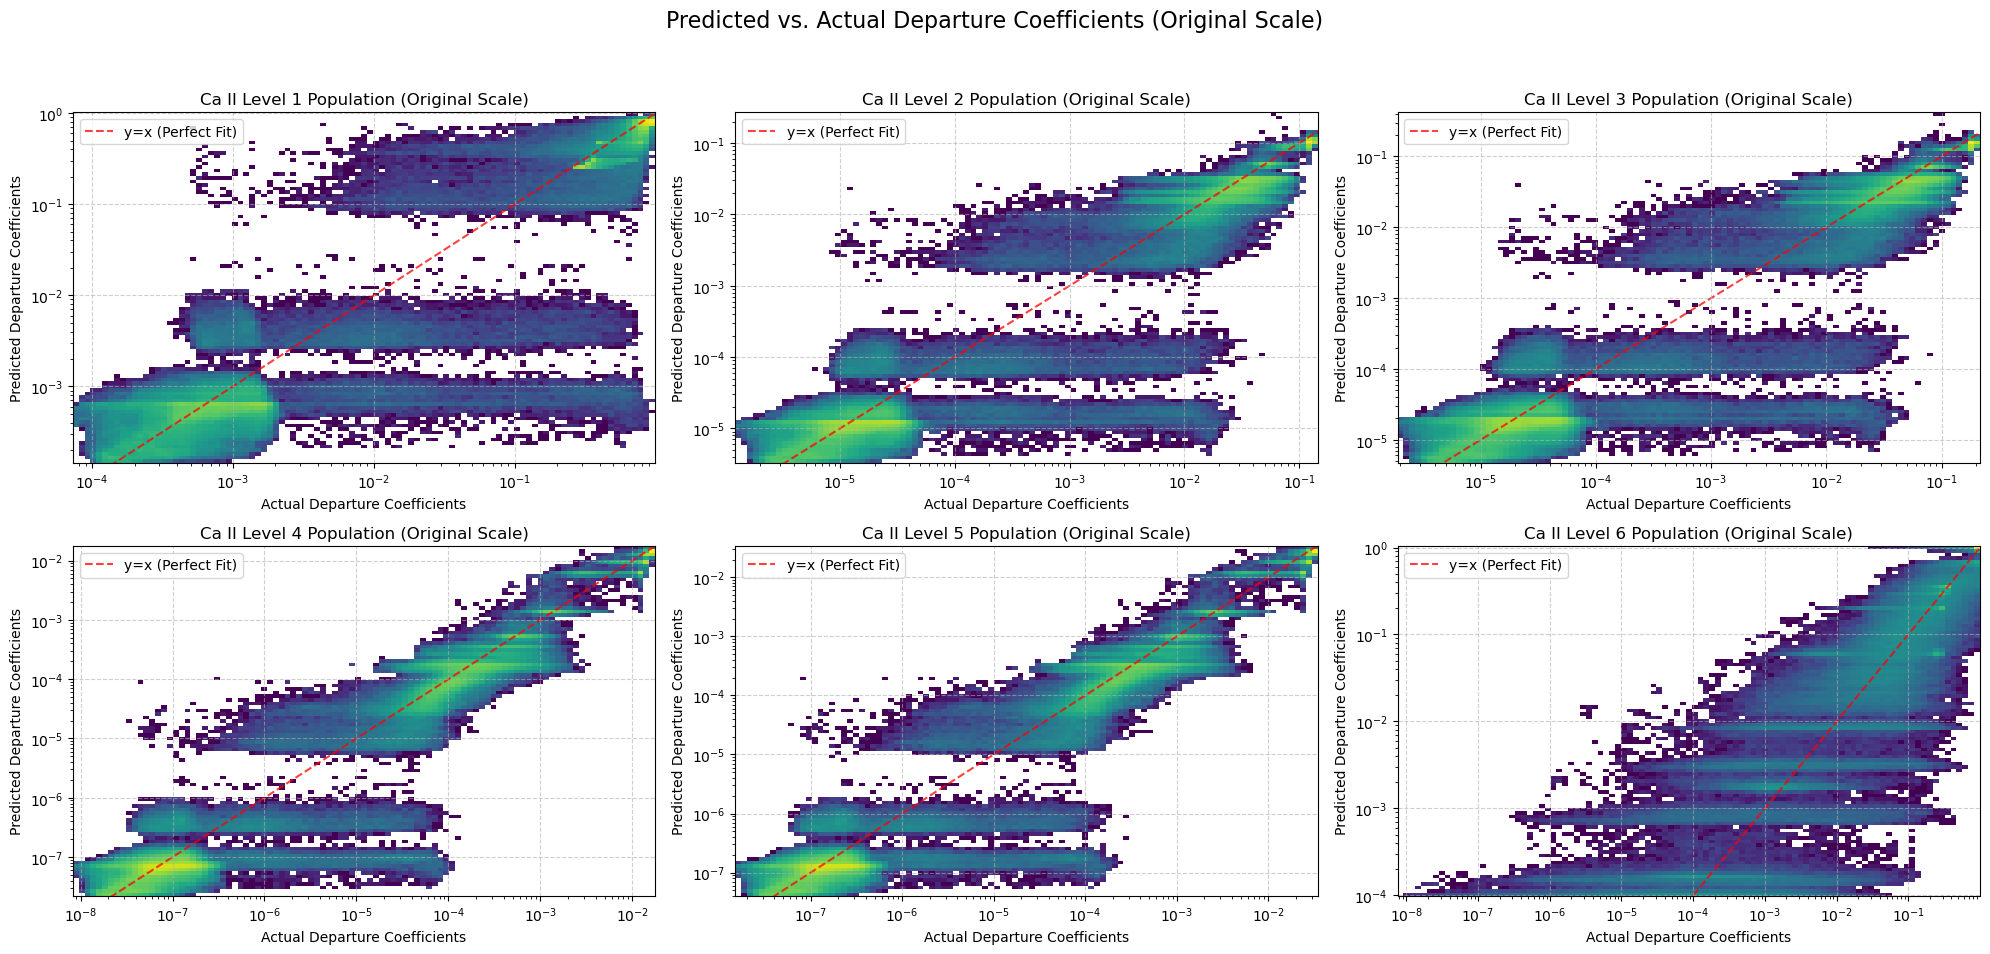

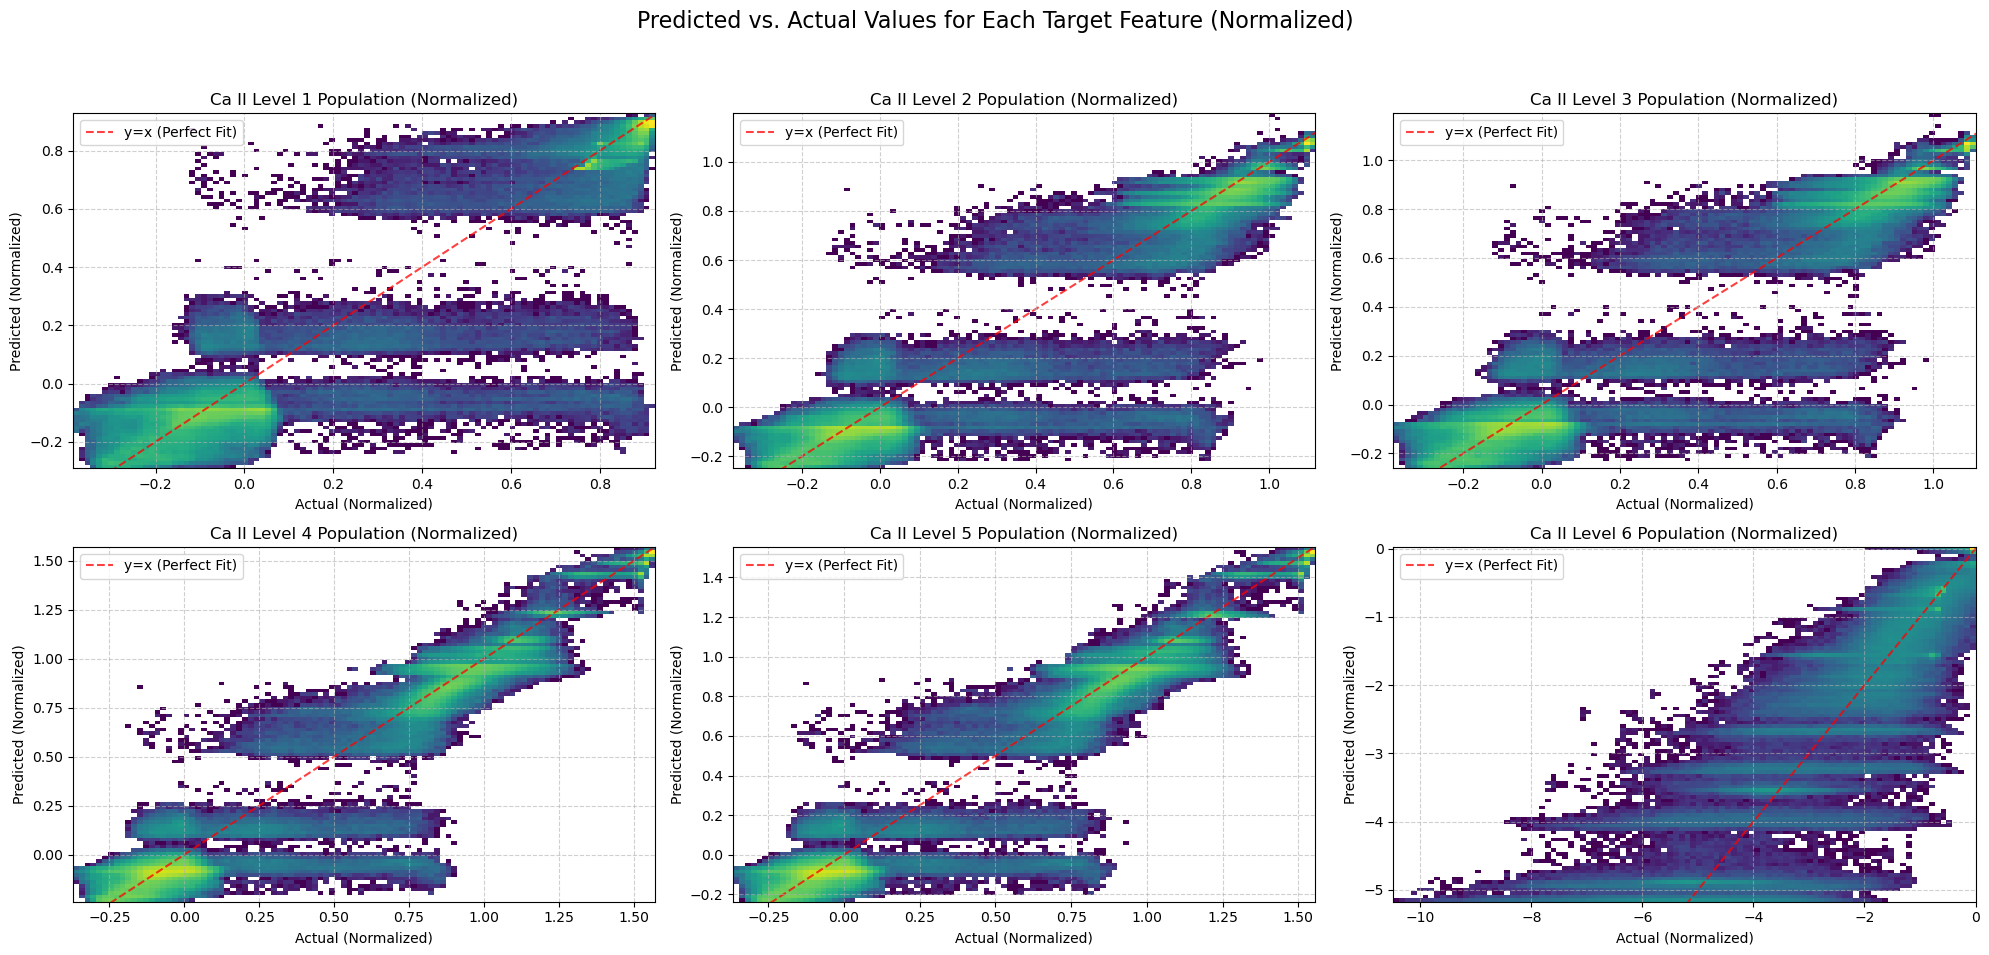

In [15]:
import matplotlib.colors as colors

# Assuming 'predictions_denorm' and 'targets_denorm' are defined elsewhere
# For example:
# predictions_denorm = np.random.rand(10000, 6) * 1e-4 + 1e-8
# targets_denorm = predictions_denorm * (np.random.rand(10000, 6) * 0.4 + 0.8)


fig, axes = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
axes = axes.flatten()

for i in range(predictions_denorm.shape[1]):
    ax = axes[i]

    # --- FIX STARTS HERE ---
    
    # Define the number of bins
    num_bins = 100
    
    # Get the min and max values for the axes, adding a small epsilon to avoid log(0)
    xmin = np.min(targets_denorm[:, i][targets_denorm[:, i] > 0])
    xmax = np.max(targets_denorm[:, i])
    ymin = np.min(predictions_denorm[:, i][predictions_denorm[:, i] > 0])
    ymax = np.max(predictions_denorm[:, i])
    
    # Create logarithmically spaced bin edges
    bins_x = np.logspace(np.log10(xmin), np.log10(xmax), num_bins)
    bins_y = np.logspace(np.log10(ymin), np.log10(ymax), num_bins)

    # Plot using the custom log-spaced bins
    ax.hist2d(targets_denorm[:, i], predictions_denorm[:, i], bins=[bins_x, bins_y], norm=colors.LogNorm())
    
    # --- FIX ENDS HERE ---

    # Add the y=x line for reference
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=1, label='y=x (Perfect Fit)')
    
    ax.set_title(f'Ca II Level {i+1} Population (Original Scale)')
    ax.set_xlabel('Actual Departure Coefficients')
    ax.set_ylabel('Predicted Departure Coefficients')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='upper left')

fig.suptitle('Predicted vs. Actual Departure Coefficients (Original Scale)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Also show normalized values for comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
axes = axes.flatten()

for i in range(predictions.shape[1]):
    ax = axes[i]

    ax.hist2d(targets[:, i], predictions[:, i], num_bins, norm=colors.LogNorm())
    
    # Add the y=x line for reference
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=1, label='y=x (Perfect Fit)')
    
    ax.set_title(f'Ca II Level {i+1} Population (Normalized)')
    ax.set_xlabel('Actual (Normalized)')
    ax.set_ylabel('Predicted (Normalized)')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='upper left')

fig.suptitle('Predicted vs. Actual Values for Each Target Feature (Normalized)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

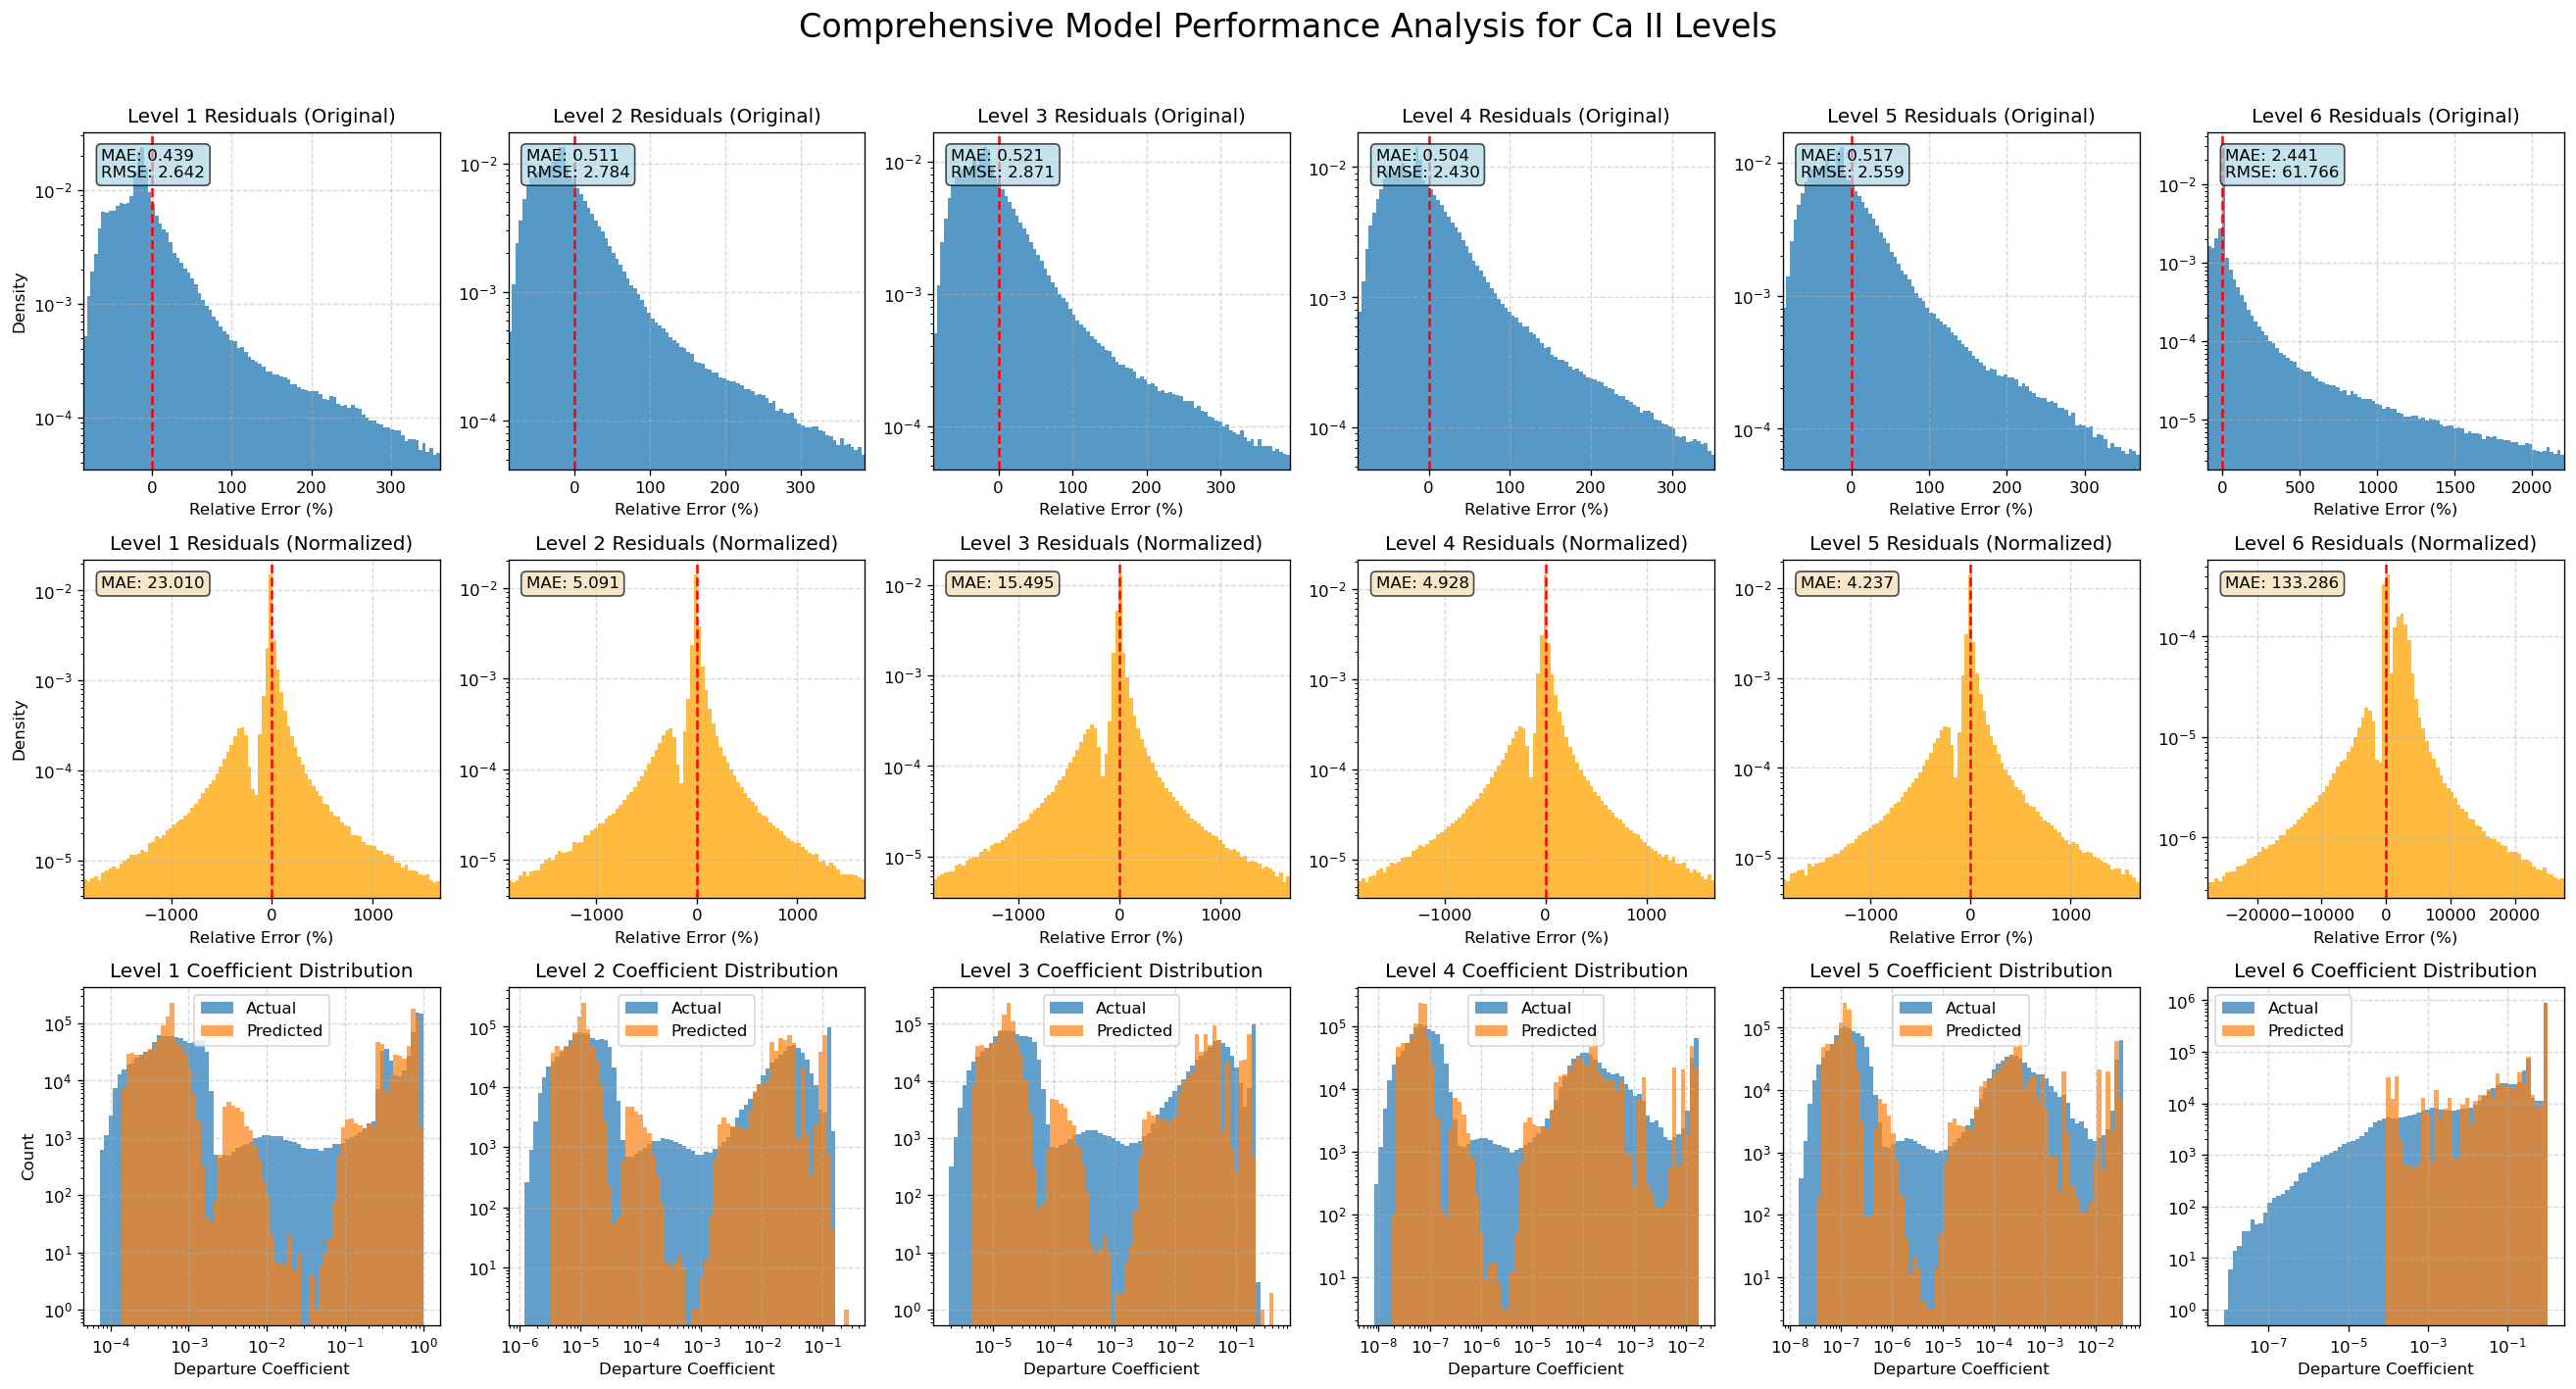

In [16]:
# Determine the number of levels to plot (e.g., 6)
num_levels = residuals_denorm.shape[1]

# Create a single figure with 3 rows for different plot types
fig, axes = plt.subplots(3, num_levels, figsize=(22, 12), dpi=120)

fig.suptitle('Comprehensive Model Performance Analysis for Ca II Levels', fontsize=20)

for i in range(num_levels):
    
    # --- Row 1: Residuals on Original Scale ---
    ax1 = axes[0, i]
    data = residuals_denorm[:, i] * 100
    
    # Dynamically set x-limits to show the bulk of the distribution
    lower, upper = np.percentile(data, [1, 99])
    ax1.set_xlim(lower, upper)
    
    ax1.hist(data, bins=100, range=(lower, upper), density=True, alpha=0.75)
    ax1.axvline(0, color='r', linestyle='--', label='Perfect Fit') # Add reference line
    ax1.set_title(f'Level {i+1} Residuals (Original)')
    ax1.set_xlabel('Relative Error (%)')
    ax1.set_yscale('log')
    if i == 0:
        ax1.set_ylabel('Density')
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.text(0.05, 0.95, f'MAE: {mae_denorm[i]:.3f}\nRMSE: {rmse_denorm[i]:.3f}', 
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.3', fc='lightblue', alpha=0.7))

    # --- Row 2: Residuals on Normalized Scale ---
    ax2 = axes[1, i]
    data = residuals_normalized[:, i] * 100
    
    # Dynamically set x-limits
    lower, upper = np.percentile(data, [1, 99])
    ax2.set_xlim(lower, upper)

    ax2.hist(data, bins=100, range=(lower, upper), density=True, alpha=0.75, color='orange')
    ax2.axvline(0, color='r', linestyle='--') # Add reference line
    ax2.set_title(f'Level {i+1} Residuals (Normalized)')
    ax2.set_xlabel('Relative Error (%)')
    ax2.set_yscale('log')
    if i == 0:
        ax2.set_ylabel('Density')
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.text(0.05, 0.95, f'MAE: {mae_normalized[i]:.3f}', 
             transform=ax2.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.7))

    # --- Row 3: Distribution of Departure Coefficients ---
    ax3 = axes[2, i]
    
    # Combine data to find overall range for binning
    combined_data = np.concatenate((targets_denorm[:, i], predictions_denorm[:, i]))
    # Create logarithmically spaced bins
    bins = np.logspace(np.log10(combined_data.min()), np.log10(combined_data.max()), 75)
    
    ax3.hist(targets_denorm[:, i], bins=bins, alpha=0.7, label='Actual')
    ax3.hist(predictions_denorm[:, i], bins=bins, alpha=0.7, label='Predicted')
    ax3.set_title(f'Level {i+1} Coefficient Distribution')
    ax3.set_xlabel('Departure Coefficient')
    if i == 0:
        ax3.set_ylabel('Count')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.grid(True, linestyle='--', alpha=0.5)
    ax3.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()